# Finetune Pix2Struct model on UI2Code dataset

## Setup Envirnoment

In [ ]:
!pip install transformers==4.33.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00


In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


## Import necessary libraries

In [ ]:
from google.colab import drive
import os
import zipfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import re
from transformers import Pix2StructForConditionalGeneration, AutoProcessor
import torch
from torch.nn import functional as F
from transformers.optimization import Adafactor, get_cosine_schedule_with_warmup
from pathlib import Path
from nltk import edit_distance
import numpy as np
import wandb
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from torch.utils.data import random_split
import random
import json

## Define variables and parameters

In [ ]:
G_DRIVE_FOLDER = '/content/drive/MyDrive/Datasets/'
G_DRIVE_FOLDER_CHECKPOINTS = '/content/drive/MyDrive/Checkpoints/'
DATASET_NAME = 'ui2code_10000'
ZIP_NAME = DATASET_NAME + '.zip'
DESTINATION_FOLDER= '/content/data/'
DATASET_FOLDER = DESTINATION_FOLDER + DATASET_NAME # unzipped name is output

EXPERIMENT_NAME = "Pix2Struct_UI2Code_Complete_3"

MAX_SENTENCE_LEN = 512

MAX_PATCHES = 1024

DEBUG = False
VERBOSE = True

BATCH_SIZE = 4
NUM_WARMUP_STEPS = 5000
MAX_EPOCHS = 10
LR = 1e-4
CHECK_VAL_EVERY_N_EPOCH = 5
GRADIENT_CLIP_VAL = 1.0
ACCUMULATE_GRAD_BATCHES = 8 / BATCH_SIZE

TRAIN_SET_PERCENTAGE = 0.898
VALID_SET_PERCENTAGE = 0.002 # Use 20 samples for validation
# TEST_SET_PERCENTAGE is 1 - TRAIN_SET_PERCENTAGE - VALID_SET_PERCENTAGE # Use 1000 for test


RANDOM_SEED = 100

LOAD_FROM_CHECKPOINT = False
LAST_CHECKPOINT_NAME = ""

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Load UI2Code Dataset

### Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Download and unzip Rico Dataset

In [ ]:
os.makedirs(DESTINATION_FOLDER, exist_ok=True)

with zipfile.ZipFile(G_DRIVE_FOLDER + ZIP_NAME, "r") as zf:
    zf.extractall(DESTINATION_FOLDER)

## Load Model and Processor

In [ ]:
repo_id = "google/pix2struct-base"

processor = AutoProcessor.from_pretrained(repo_id)
model = Pix2StructForConditionalGeneration.from_pretrained(repo_id, is_encoder_decoder=True)

(…)se/resolve/main/preprocessor_config.json:   0%|          | 0.00/231 [00:00<?, ?B/s]

(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

(…)2struct-base/resolve/main/tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

(…)ase/resolve/main/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

(…)pix2struct-base/resolve/main/config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

## Create Dataset class

## Load list of files and display some of them

In [ ]:
all_paths = [filename.split(".txt")[0] for filename in os.listdir(DATASET_FOLDER) if filename.endswith(".txt")]

In [ ]:
len(all_paths)

10000

In [ ]:
with open(DATASET_FOLDER + "/" + all_paths[0] + ".txt", "r") as f:
    print(f.read())

android.widget.FrameLayout android.widget.RelativeLayout { android.widget.TextView } android.widget.FrameLayout { android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView } android.widget.TextView android.widget.ListView { android.widget.RelativeLayout { android.widget.TextView android.widget.TextView } android.widget.RelativeLayout { android.widget.TextView android.widget.TextView } android.widget.RelativeLayout { android.widget.TextView android.widget.TextView } }


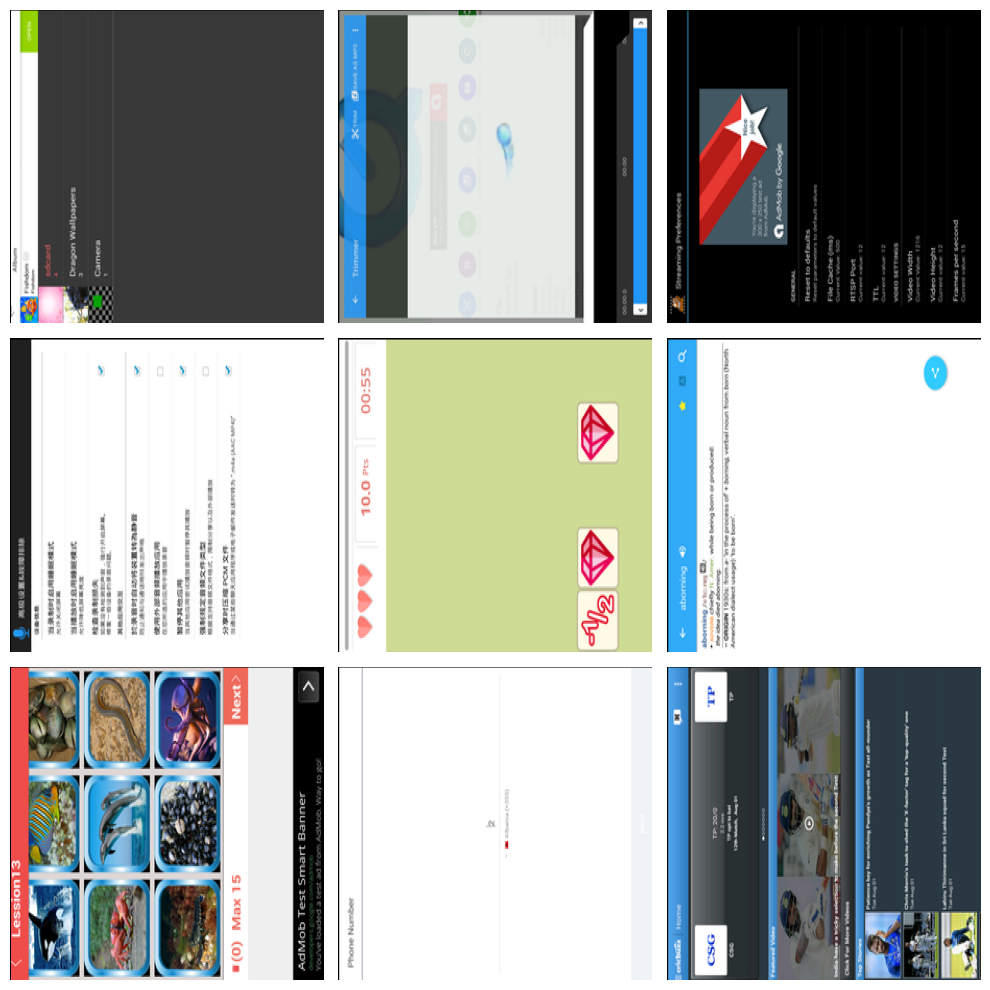

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Create a new figure
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the image paths and plot them
for i, path in enumerate(all_paths[:9]):
    img = Image.open(DATASET_FOLDER + "/" + path + ".png")

    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis("off")
    ax.set_aspect('auto')
plt.tight_layout()
plt.show()


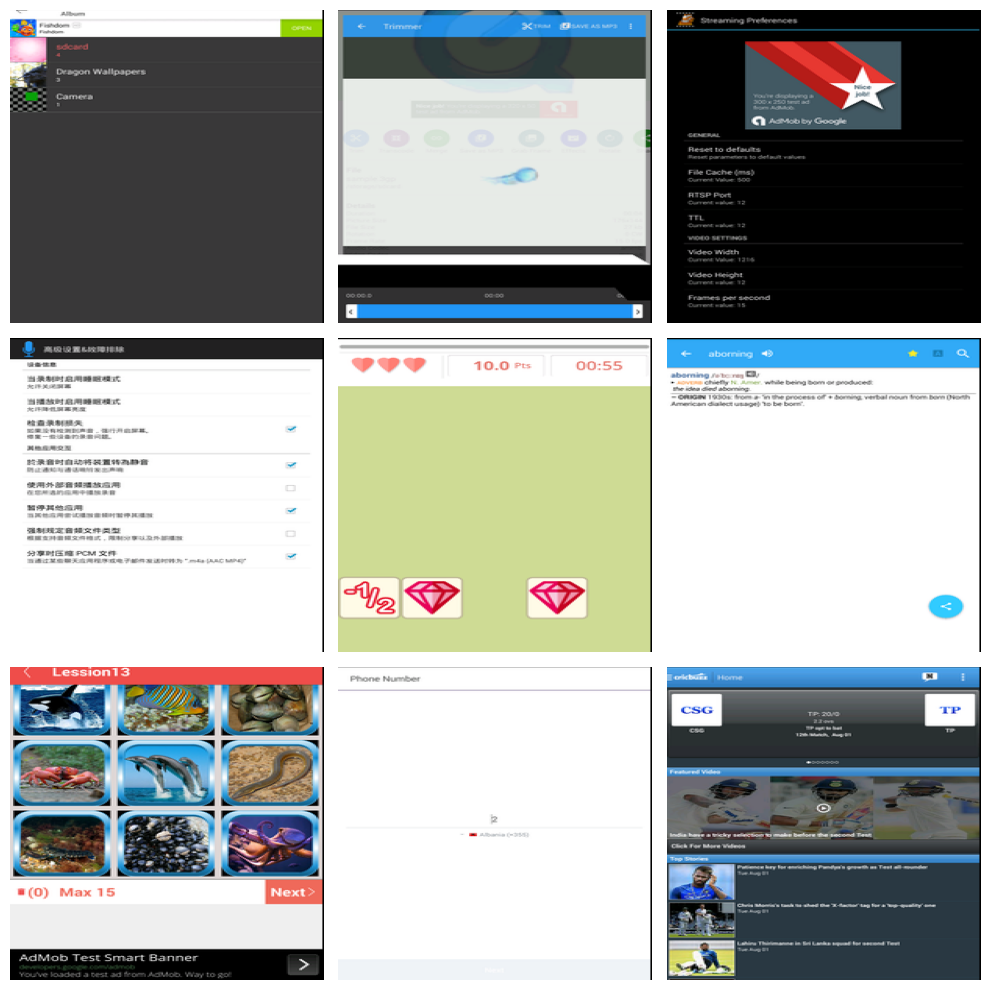

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Create a new figure
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the image paths and plot them
for i, path in enumerate(all_paths[:9]):
    img = Image.open(DATASET_FOLDER + "/" + path + ".png")
    img_rotated = img.rotate(-90, expand=1)  # rotating image 90 degrees clockwise

    ax = axs[i // 3, i % 3]
    ax.imshow(img_rotated)
    ax.axis("off")
    ax.set_aspect('auto')
plt.tight_layout()
plt.show()


### Find max sentence length and new unknown tokens, filter files bigger than max sentence len

In [ ]:
# Find max length
max_length = 0
filtered_paths = []

# Read text files and add new tokens to dictionary
tokens_to_add = set()
for path in tqdm(all_paths):
    with open(DATASET_FOLDER + "/" + path + ".txt", "r") as f:
        content = f.read()
        splitted_text = processor.tokenizer(content).tokens()
    # Check if the current sentence has the largest number of tokens
    if len(splitted_text) > max_length:
        max_length = len(splitted_text)

    if len(splitted_text) <= MAX_SENTENCE_LEN:
        filtered_paths.append(path)
        tokens_to_add = tokens_to_add.union(set(splitted_text))

print(f"Max sentence length = {max_length}")

newly_added_num = processor.tokenizer.add_tokens(list(tokens_to_add))
print(f"Number of new tokens = {newly_added_num}")

# Resize the model's token embeddings if there are new tokens
if newly_added_num > 0:
    model.decoder.resize_token_embeddings(len(processor.tokenizer), pad_to_multiple_of=8)

100%|██████████| 10000/10000 [00:03<00:00, 2829.56it/s]


Max sentence length = 444
Number of new tokens = 12


In [ ]:
# Keep only the samples with number of tokens lower than Max Sentence Length
all_paths = filtered_paths

In [ ]:
print(len(all_paths))

10000


In [ ]:
print(all_paths[:5])

['38035fe2ac6d08630547671d1840e1ade604251bcad7f8953c01e18f', 'b45a62b0975ceb33a69d15cfe1bf22b8ceca50719762060c7aca4d56', '411b18b4a71cbec2d2c2cf7ec94d6a0770f663553286b5fea6600b4d', 'b56106286aa3011ecf5061994bbbcfa6a9e0c5be385896921c4b9283', '0af1a885947aa5a51a7cd85ebe8e8585a7ec64c285f99a03f643956d']


In [ ]:
all_paths = filtered_paths

### Split files into training - validation - test sets

In [ ]:
random.seed(RANDOM_SEED)

# Use the same seed, so that parts remain the same
random.shuffle(all_paths)

train_len = int(TRAIN_SET_PERCENTAGE * len(all_paths))
valid_len = int(VALID_SET_PERCENTAGE * len(all_paths))

train_paths = all_paths[:train_len]
valid_paths = all_paths[train_len:train_len+valid_len]
test_paths = all_paths[train_len+valid_len:]

print(f"TRAIN_SET size = {len(train_paths)}")
print(f"VALID_SET size = {len(valid_paths)}")
print(f"TEST_SET size = {len(test_paths)}")

TRAIN_SET size = 8980
VALID_SET size = 20
TEST_SET size = 1000


In [ ]:
class UI2CodeDataset(Dataset):
    # This is a modification of the dataset used for validation and testing
    # In this one the sentences are already split into chunks, already having
    # the context from the previous chunk, empty chunks are discarded
    def __init__(self, root_dir, transform, paths):

        self.root_dir = root_dir
        self.transform = transform
        self.paths = paths

        self.max_patches = MAX_PATCHES
        self.max_length = MAX_SENTENCE_LEN
        self.ignore_id = -100

        self.encodings = []

        for path in tqdm(paths):
            # Directly process the text files, and save them in the ram
            # Do the same also for images, if there is enough space in memory
            text_file_path = os.path.join(root_dir, path + ".txt")
            image_file_path = os.path.join(root_dir , path + ".png")

            # Each data entry has the following structure
            # labels, image_encoding_idx, part

            # image_encoding_idx points to an entry of images_encoding, which contains attention_mask and flattened_patches for the image
            # Since a single image is used for multiple slices of the same text, this approach is used to save memory

            # Load image
            # Load image
            image = Image.open(image_file_path).convert('RGB')
            image = image.rotate(-90, expand=1)

            if DEBUG:
                image.show()

            if self.transform:
                image = self.transform(image)

            encoding = processor(images=image, max_patches=self.max_patches, return_tensors="pt")
            encoding = {k:v.squeeze() for k,v in encoding.items()}

            # Load text
            with open(text_file_path, "r") as f:
                text_content = f.read()

            input_ids = processor.tokenizer(
                text_content,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            ).input_ids

            labels = input_ids.squeeze().clone()
            labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token

            encoding["labels"] = labels

            # For each sample save directly the encoding of both text and image
            self.encodings.append(encoding)

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        return self.encodings[idx]

In [ ]:
# Transformations for the image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize for pretrained models
])

# Instantiate the CustomDataset
train_dataset = UI2CodeDataset(DATASET_FOLDER, transform, train_paths)
val_dataset = UI2CodeDataset(DATASET_FOLDER, transform, valid_paths)

# Use DataLoader for batching and shuffling
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False) # Use 10 as batch for testing since they are lighter

100%|██████████| 20/20 [00:00<00:00, 84.78it/s]


In [ ]:
print(f"train_dataloader size = {len(train_dataloader)}")
print(f"val_dataloader size = {len(val_dataloader)}")

train_dataloader size = 2245
val_dataloader size = 2


In [ ]:
batch = next(iter(train_dataloader))
encoding = batch

In [ ]:
encoding

{'flattened_patches': tensor([[[ 1.0000e+00,  1.0000e+00, -2.7125e+00,  ...,  6.5336e-01,
            7.9184e-01,  9.5481e-01],
          [ 1.0000e+00,  2.0000e+00, -2.7125e+00,  ...,  6.5336e-01,
            7.9184e-01,  9.5481e-01],
          [ 1.0000e+00,  3.0000e+00, -2.7125e+00,  ...,  6.5336e-01,
            7.9184e-01,  9.5481e-01],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 1.0000e+00,  1.0000e+00, -2.8768e+00,  ..., -2.4529e+00,
           -2.3950e+00, -2.2103e+00],
          [ 1.0000e+00,  2.0000e+00, -2.8768e+00,  ..., -2.4529e+00,
           -2.3950e+00, -2.2103e+00],
          [ 1.0000e+00,  3.0000e+00, -2.8768e+00,  ..., -2.4529e+00,
           -2.3950e+00, -2.2103e+00]

In [ ]:
encoding["flattened_patches"][0]

tensor([[ 1.0000,  1.0000, -2.7125,  ...,  0.6534,  0.7918,  0.9548],
        [ 1.0000,  2.0000, -2.7125,  ...,  0.6534,  0.7918,  0.9548],
        [ 1.0000,  3.0000, -2.7125,  ...,  0.6534,  0.7918,  0.9548],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
encoding["labels"]

tensor([[ 3550,   274, 13717,  ...,  -100,  -100,  -100],
        [ 3550,   274, 10412,  ...,  -100,  -100,  -100],
        [ 3550,   274, 13717,  ...,  -100,  -100,  -100],
        [ 3550,   274, 13717,  ...,  -100,  -100,  -100]])

In [ ]:
encoding["labels"][0]

tensor([ 3550,   274, 13717,   274,  6118,  7586,  3550,   274, 13717,   274,
        29301,  3550,   274, 13717,   274,  6118,  3920,  3550,   274, 10412,
          274,   703,   289,   274,  4060,   274,  3920,  6506,   574,   435,
         3550,   274, 13717,   274, 25383,  3920,   435,  3550,   274, 13717,
          274, 10446, 13142,   435,  3550,   274, 13717,   274, 29301,  3550,
          274, 13717,   274, 29301,  3550,   274, 13717,   274, 29301,  3550,
          274, 13717,   274, 29301,   512,  3550,   274, 13717,   274,  7586,
         3550,   274, 13717,   274, 29301,  3550,   274, 13717,   274, 29301,
         3550,   274, 13717,   274, 29301,  3550,   274, 13717,   274, 29301,
         3550,   274, 13717,   274, 43727, 18191, 13142,  3550,   274, 13717,
          274, 43727, 18191, 13142,  3550,   274, 13717,   274, 43727, 18191,
        13142,  3550,   274, 13717,   274, 43727, 18191, 13142,  3550,   274,
        13717,   274, 29301,   512,   512,     1,  -100,  -100, 

In [ ]:
labels_list = encoding["labels"][0].tolist()

# Filter out the -100 values
filtered_labels = [token for token in labels_list if token != -100]

# Decode the cleaned list of tokens
decoded_text_example = processor.tokenizer.batch_decode([filtered_labels], skip_special_tokens=True)[0]


In [ ]:
decoded_text_example

'android.widget.ImageButton android.widget.TextView android.widget.ImageView android.support.v4.view.ViewPager { android.widget.ScrollView { android.widget.FrameLayout { android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView } android.widget.Button android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.RelativeLayout android.widget.RelativeLayout android.widget.RelativeLayout android.widget.RelativeLayout android.widget.TextView } }'

In [ ]:
for k,v in encoding.items():
    print(k,v.shape)

flattened_patches torch.Size([4, 1024, 770])
attention_mask torch.Size([4, 1024])
labels torch.Size([4, 512])


## Training

In [ ]:
START_TOKEN_ID = PAD_TOKEN_ID = processor.tokenizer.pad_token_id

### Utility functions

In [ ]:
def move_to_device(data):
    if isinstance(data, (list,tuple)):
        return [move_to_device(x) for x in data]
    elif isinstance(data, dict):
        return {k: move_to_device(v) for k, v in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.to(DEVICE)
    else:
        return data

### Main training function

In [ ]:
def train_model(config, processor, model, train_dataloader, val_dataloader):
    # Extract configuration values
    lr = config.get("lr")
    max_epochs = config.get("max_epochs")
    num_warmup_steps = config.get("num_warmup_steps")

    model.to(DEVICE)

    optimizer = Adafactor(model.parameters(), scale_parameter=False, relative_step=False, lr=lr, weight_decay=1e-05)

    # Use total steps (i.e., max_epochs * length_of_train_data)
    total_steps = max_epochs * len(train_dataloader)
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=num_warmup_steps,
                                                num_training_steps=total_steps)

    global_step = 0  # to keep track of total steps
    epoch_start = 0

    wandb.init(project="Pix2Struct", name="run-" + EXPERIMENT_NAME, config=config)

    #epoch_last = epoch_start + max_epochs - 1
    epoch_last = max_epochs - 1
    #for epoch in range(epoch_start, epoch_start + max_epochs):
    for epoch in range(epoch_start, max_epochs):
        global_step, moving_avg_loss = training_loop(epoch, train_dataloader, model, config, optimizer, scheduler, global_step, epoch_last)

        if config.get("verbose", False):
            print(f"Moving Avg Loss: {moving_avg_loss:.3f}")

        wandb.log({"moving_avg_loss": moving_avg_loss, **{f'lr_{i}': param_group['lr'] for i, param_group in enumerate(optimizer.param_groups)}})

        # Save the model after each validation step
        save_checkpoint(model, optimizer, scheduler, epoch, global_step, wandb.run.id, EXPERIMENT_NAME, G_DRIVE_FOLDER_CHECKPOINTS)

        #if epoch == 0 + epoch_start or epoch == epoch_last or (epoch + 1) % config.get("check_val_every_n_epoch") == 0:
        if epoch == 0 or epoch == epoch_last or (epoch + 1) % config.get("check_val_every_n_epoch") == 0:
            avg_bleu_score = testing_loop(val_dataloader, model, processor, config, f"Epoch {epoch}/{epoch_last} - valid loop")

            if config.get("verbose", False):
                print(f" Avg Bleu Score: {avg_bleu_score:.2f}")

            wandb.log({"bleu": avg_bleu_score})

    wandb.finish()

In [ ]:
def training_loop(epoch, train_dataloader, model, config, optimizer, scheduler, global_step, epoch_last):
    model.train()
    train_loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch}/{epoch_last} - train loop")

    # Extract configuration values
    accumulate_grad_batches = config.get('accumulate_grad_batches', 1)
    gradient_clip_val = config.get("gradient_clip_val")

    moving_avg_loss = 0
    alpha = 0.1 # Smoothing factor

    for step, batch in train_loop:
        encoding = move_to_device(batch)
        labels, flattened_patches, attention_mask = encoding["labels"], encoding["flattened_patches"], encoding["attention_mask"]

        outputs = model(labels=labels, flattened_patches=flattened_patches, attention_mask=attention_mask)
        loss = outputs.loss
        loss.backward()

        if global_step % accumulate_grad_batches == 0 or step == len(train_dataloader) - 1:
            if gradient_clip_val:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
            optimizer.step()
            optimizer.zero_grad()

        # Update the progress bar
        train_loop.set_postfix({'loss': loss.item()}, refresh=True)

        scheduler.step()
        global_step += 1

        # Update the moving average loss
        moving_avg_loss = loss.item() if moving_avg_loss == 0 else alpha * loss.item() + (1 - alpha) * moving_avg_loss

        # Log Loss after each step
        wandb.log({"loss": loss.item()})

    return global_step, moving_avg_loss

In [ ]:
def testing_loop(testing_dataloader, model, processor, config, description, generation_config=None):

    model.eval()
    bleu_scores = []

    with torch.no_grad():
        test_loop = tqdm(enumerate(testing_dataloader), total=len(testing_dataloader), desc=description)
        for i, batch in test_loop:
            encoding = move_to_device(batch)
            labels, flattened_patches, attention_mask = encoding["labels"], encoding["flattened_patches"], encoding["attention_mask"]

            outputs = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_new_tokens=MAX_SENTENCE_LEN, generation_config=generation_config)

            predictions = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)

            labels[labels == -100] = 0
            answers = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

            bleus = [corpus_bleu([[answer]], [pred], smoothing_function=SmoothingFunction().method4) for pred, answer in zip(predictions, answers)]
            bleu_scores += bleus

            avg_bleu_score = np.mean(bleu_scores)
            test_loop.set_postfix(bleu_score=avg_bleu_score)

            if config.get("verbose", False):
                for pred, answer, bleu_score in zip(predictions, answers, bleus):
                    tqdm.write(f"\nPrediction: {pred}\n    Answer: {answer}\n      Bleu: {bleu_score:.2f}")

    return avg_bleu_score


In [ ]:
def save_checkpoint(model, optimizer, scheduler, epoch, global_step, wandb_run_id, experiment_name, folder_path):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "epoch": epoch,
        "global_step": global_step,
        'wandb_run_id': wandb_run_id
    }
    model_name = f"{experiment_name}_epoch[{epoch}].pth"
    torch.save(checkpoint, folder_path + model_name)


In [ ]:
config = {
          "batch_size": BATCH_SIZE,
          "num_warmup_steps": NUM_WARMUP_STEPS,
          "max_epochs": MAX_EPOCHS,
          "lr": LR,
          "check_val_every_n_epoch": CHECK_VAL_EVERY_N_EPOCH,
          "gradient_clip_val": GRADIENT_CLIP_VAL,
          "accumulate_grad_batches": ACCUMULATE_GRAD_BATCHES,
          "verbose": VERBOSE,
}

In [ ]:
def validate_config(config):
    # Check required keys
    required_keys = [
        "batch_size",
        "num_warmup_steps",
        "max_epochs",
        "lr",
        "check_val_every_n_epoch",
        "gradient_clip_val",
        "accumulate_grad_batches",
        "verbose"
    ]
    for key in required_keys:
        if key not in config:
            raise ValueError(f"Key '{key}' must be present in the configuration.")

    # Check that values are in expected ranges
    if config["batch_size"] <= 0:
        raise ValueError("batch_size must be positive.")
    if config["num_warmup_steps"] < 0:
        raise ValueError("num_warmup_steps must be non-negative.")
    if config["max_epochs"] <= 0:
        raise ValueError("max_epochs must be positive.")
    if config["lr"] <= 0:
        raise ValueError("Learning rate must be positive.")
    if config["check_val_every_n_epoch"] <= 0:
        raise ValueError("check_val_every_n_epoch must be positive.")
    if config["gradient_clip_val"] < 0:
        raise ValueError("gradient_clip_val must be non-negative.")
    if config["accumulate_grad_batches"] <= 0:
        raise ValueError("accumulate_grad_batches must be positive.")
    if not isinstance(config["verbose"], bool):
        raise ValueError("verbose must be a boolean value.")


In [ ]:
validate_config(config)
print(config)

{'batch_size': 4, 'num_warmup_steps': 5000, 'max_epochs': 10, 'lr': 0.0001, 'check_val_every_n_epoch': 5, 'gradient_clip_val': 1.0, 'accumulate_grad_batches': 2.0, 'verbose': True}


In [ ]:
train_model(config, processor, model, train_dataloader, val_dataloader)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 0/9 - train loop: 100%|██████████| 2245/2245 [20:00<00:00,  1.87it/s, loss=0.245]


Moving Avg Loss: 0.330


Epoch 0/9 - valid loop:  50%|█████     | 1/2 [00:48<00:48, 48.61s/it, bleu_score=0.227]


Prediction: android.widget.ImageButton android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView 

Epoch 0/9 - valid loop: 100%|██████████| 2/2 [01:35<00:00, 47.67s/it, bleu_score=0.221]



Prediction: android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView and

Epoch 1/9 - train loop: 100%|██████████| 2245/2245 [19:55<00:00,  1.88it/s, loss=0.317]


Moving Avg Loss: 0.278


Epoch 2/9 - train loop: 100%|██████████| 2245/2245 [19:55<00:00,  1.88it/s, loss=0.132]


Moving Avg Loss: 0.179


Epoch 3/9 - train loop: 100%|██████████| 2245/2245 [19:57<00:00,  1.87it/s, loss=0.216]


Moving Avg Loss: 0.199


Epoch 4/9 - train loop: 100%|██████████| 2245/2245 [19:55<00:00,  1.88it/s, loss=0.154]


Moving Avg Loss: 0.167


Epoch 4/9 - valid loop:  50%|█████     | 1/2 [00:46<00:46, 46.81s/it, bleu_score=0.452]


Prediction: android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView and

Epoch 4/9 - valid loop: 100%|██████████| 2/2 [01:33<00:00, 46.77s/it, bleu_score=0.479]



Prediction: android.widget.ImageButton android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView 

Epoch 5/9 - train loop: 100%|██████████| 2245/2245 [19:57<00:00,  1.87it/s, loss=0.0951]


Moving Avg Loss: 0.138


Epoch 6/9 - train loop: 100%|██████████| 2245/2245 [19:57<00:00,  1.87it/s, loss=0.104]


Moving Avg Loss: 0.082


Epoch 7/9 - train loop: 100%|██████████| 2245/2245 [19:54<00:00,  1.88it/s, loss=0.0426]


Moving Avg Loss: 0.103


Epoch 8/9 - train loop: 100%|██████████| 2245/2245 [19:57<00:00,  1.88it/s, loss=0.0653]


Moving Avg Loss: 0.072


Epoch 9/9 - train loop: 100%|██████████| 2245/2245 [19:57<00:00,  1.87it/s, loss=0.0698]


Moving Avg Loss: 0.080


Epoch 9/9 - valid loop:  50%|█████     | 1/2 [00:46<00:46, 46.77s/it, bleu_score=0.69]


Prediction: android.widget.LinearLayout android.widget.LinearLayout android.widget.LinearLayout android.widget.TabHost { android.widget.TabWidget_horizontal { android.widget.RelativeLayout { android.widget.TextView } android.widget.RelativeLayout { android.widget.TextView } android.widget.RelativeLayout { android.widget.TextView } } android.widget.FrameLayout { android.widget.RadioButton android.widget.RadioButton android.widget.RadioButton android.widget.RadioButton android.support.v4.view.ViewPager { android.widget.GridView { android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout android.widget.FrameLayout androi

Epoch 9/9 - valid loop: 100%|██████████| 2/2 [01:33<00:00, 46.76s/it, bleu_score=0.655]


Prediction: android.widget.TextView android.widget.TextView android.widget.ImageView android.widget.HorizontalScrollView_horizontal { sj { android.widget.TextView } sj { android.widget.TextView } sj { android.widget.TextView } sj { android.widget.TextView } } android.support.v4.view.ViewPager { android.support.v7.widget.RecyclerView { android.widget.FrameLayout { android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView } android.widget.FrameLayout { android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView } android.widget.FrameLayout { android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView } android.widget.FrameLayout { android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView android.widget.TextView } android.widget.FrameLayout { android.widget.TextView andro

bleu,▁▅█
loss,█▂▃▂▂▃▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▄▇█▇▆▅▃▂▁▁
moving_avg_loss,█▇▄▄▄▃▁▂▁▁
bleu,0.65489
loss,0.06976
lr_0,0.0
moving_avg_loss,0.08008
